# Binary CIFAR10 Label 3 and label 4 /  3->1 4->0 / 3 is positive 4 is negative KNN

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath("/Users/max/MasterThesis/Training/"))

In [2]:
import torch
from torch.utils.data import DataLoader, Subset, ConcatDataset, TensorDataset
from torchvision import datasets, transforms
import numpy as np

# CIFAR10 数据归一化参数
# 数据预处理
cifar10_transforms = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
# 加载 CIFAR10 数据集
full_train_dataset = datasets.CIFAR10(
    root="/Users/max/MasterThesisData/CIFAR10", train=True, transform=cifar10_transforms, download=True)
full_test_dataset = datasets.CIFAR10(
    root="/Users/max/MasterThesisData/CIFAR10", train=False, transform=cifar10_transforms, download=True)

# 筛选训练集中的标签 3 和 4，并映射标签（标签 3 -> 1，标签 4 -> 0）
indices3_train = [i for i in range(len(full_train_dataset)) if full_train_dataset.targets[i] == 3]
indices4_train = [i for i in range(len(full_train_dataset)) if full_train_dataset.targets[i] == 4]

# 筛选测试集中的标签 3 和 4，并映射标签
indices3_test = [i for i in range(len(full_test_dataset)) if full_test_dataset.targets[i] == 3]
indices4_test = [i for i in range(len(full_test_dataset)) if full_test_dataset.targets[i] == 4]

# 训练集：获取标签为 3 的数据（映射为 1）
cifar3_train_data = full_train_dataset.data[indices3_train]  # numpy 数组，形状 (n, 32, 32, 3)
cifar3_train_labels = torch.ones(len(indices3_train), dtype=torch.long)

# 训练集：获取标签为 4 的数据（映射为 0）
cifar4_train_data = full_train_dataset.data[indices4_train]
cifar4_train_labels = torch.zeros(len(indices4_train), dtype=torch.long)

# 测试集：获取标签为 3 的数据（映射为 1）
cifar3_test_data = full_test_dataset.data[indices3_test]
cifar3_test_labels = torch.ones(len(indices3_test), dtype=torch.long)

# 测试集：获取标签为 4 的数据（映射为 0）
cifar4_test_data = full_test_dataset.data[indices4_test]
cifar4_test_labels = torch.zeros(len(indices4_test), dtype=torch.long)

# 控制不平衡比例，比如这里设定为 0.005（即只选取标签 4 数据中的一小部分）
## 0.005 0.01 0.02 0.05 0.1 0.2 
fraction = int(0.2 * len(cifar3_train_data))
selected_indices_4 = np.random.choice(len(cifar4_train_data), fraction, replace=False)
fraction_cifar4_train_data = cifar4_train_data[selected_indices_4]
fraction_cifar4_train_labels = cifar4_train_labels[selected_indices_4]

# 拼接最终的训练和测试数据集
Final_train_data = np.concatenate([cifar3_train_data, fraction_cifar4_train_data], axis=0)
Final_train_labels = torch.cat([cifar3_train_labels, fraction_cifar4_train_labels], dim=0)

Final_test_data = np.concatenate([cifar3_test_data, cifar4_test_data], axis=0)
Final_test_labels = torch.cat([cifar3_test_labels, cifar4_test_labels], dim=0)

# 将 numpy 数组转换为 tensor，并调整维度为 (N, C, H, W)
Final_train_data = torch.from_numpy(Final_train_data).permute(0, 3, 1, 2).float()
Final_test_data = torch.from_numpy(Final_test_data).permute(0, 3, 1, 2).float()

# 归一化图像数据：先除以 255，再进行标准化
# # 创建 TensorDataset
# Final_train_datasets = TensorDataset(Final_train_data.unsqueeze(3).float() / 255, Final_train_labels)
# Final_test_datasets = TensorDataset(Final_test_data.unsqueeze(3).float() / 255, Final_test_labels)

# 创建 TensorDataset
Final_train_dataset = TensorDataset(Final_train_data.float() / 255, Final_train_labels)
Final_test_dataset = TensorDataset(Final_test_data.float() / 255, Final_test_labels)

# 数据加载器
train_loader = DataLoader(Final_train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(Final_test_dataset, batch_size=64, shuffle=False)

# 打印数据信息
print("Number of label 1 in the final training set: ", len(cifar3_train_data))
print("Number of label 0 in the final training set (after downsampling): ", len(fraction_cifar4_train_data))
print("Number of label 1 in the final test set: ", len(cifar3_test_data))
print("Number of label 0 in the final test set: ", len(cifar4_test_data))

print("Total samples in final training set: ", len(Final_train_dataset))
print("Total samples in final test set: ", len(Final_test_dataset))

print("Number of batches in training set: ", len(train_loader))
print("Number of batches in test set: ", len(test_loader))


Number of label 1 in the final training set:  5000
Number of label 0 in the final training set (after downsampling):  1000
Number of label 1 in the final test set:  1000
Number of label 0 in the final test set:  1000
Total samples in final training set:  6000
Total samples in final test set:  2000
Number of batches in training set:  94
Number of batches in test set:  32


Images shape: torch.Size([64, 3, 32, 32])
Labels shape: torch.Size([64])


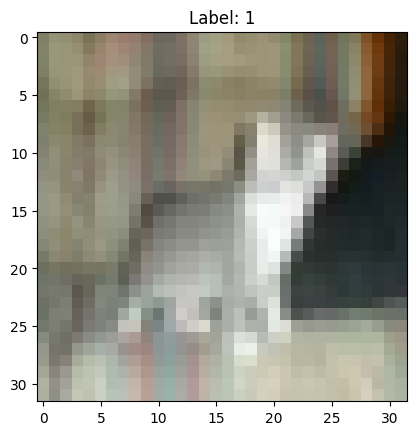

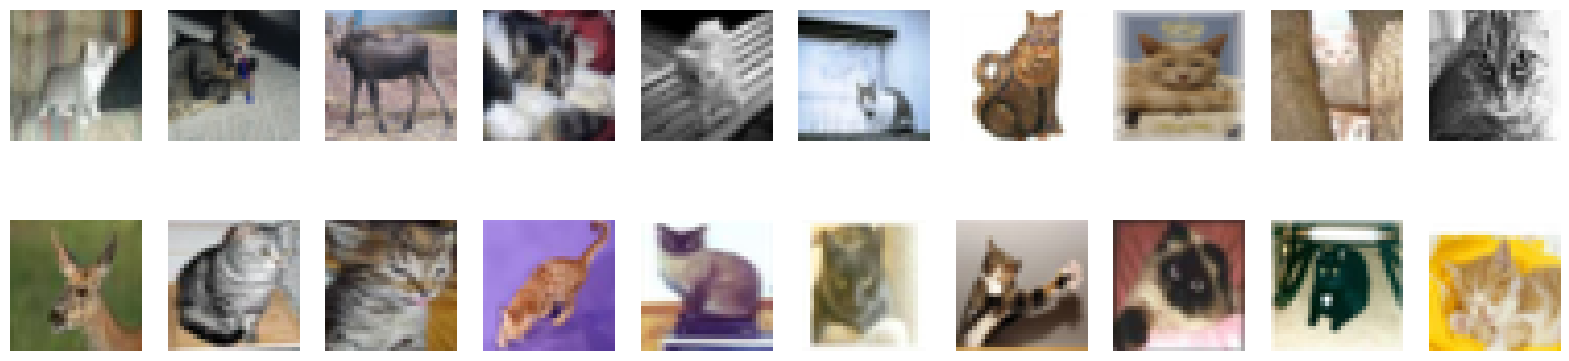

In [3]:

## 获取一个 batch
images, labels = next(iter(train_loader))

# 打印张量信息
print(f"Images shape: {images.shape}")  # (batch_size, 3, 32, 32)
print(f"Labels shape: {labels.shape}")

# 将第一张图像的维度转换为 (H, W, C) 并显示
img = images[0].permute(1, 2, 0).numpy()  # (32, 32, 3)
plt.imshow(img)  # 对于彩色图像，无需指定 cmap
plt.title(f"Label: {labels[0].item()}")
plt.show()

plt.figure(figsize=(20, 5))
for i, img_tensor in enumerate(images[:20]):
    # 将每张图像转换为 (H, W, C)
    npimg = img_tensor.permute(1, 2, 0).numpy()
    plt.subplot(2, 10, i+1)
    plt.imshow(npimg)  # 彩色图像，不指定 cmap
    plt.axis('off')
plt.show()


In [4]:
X_train = []
y_train = []

for batch in train_loader:
    images, labels = batch  # images: (batch_size, 3, 28, 28), labels: (batch_size,)
    if hasattr(images, 'numpy'): # images is tensor
        images = images.numpy()
    # batch_size = 64
    for img, label in zip(images, labels):
        #print(f"Original shape: {img.shape}")  #  (3, 32, 32)  
        flattened_img = img.flatten()           
        #print(f"Flattened shape: {flattened_img.shape}")
        X_train.append(flattened_img) # (3072,)
        y_train.append(label)


X_test = [] # features
y_test = [] # labels
for batch in test_loader:
    images, labels = batch  # images: (batch_size, 3, 32, 32), labels: (batch_size,)
    if hasattr(images, 'numpy'): # images is tensor
        images = images.numpy()
    # batch_size = 64
    for img, label in zip(images, labels):
        flattened_img = img.flatten()           # (3, 32, 32) -> (3072,)
        X_test.append(flattened_img)
        y_test.append(label)


X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

# training model

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# 创建一个KNN分类器，设定邻居数为5（你可以根据需要调整n_neighbors的值）
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("y_pred.shape:", y_pred.shape)


from self_metrics import Binary_got_metrics
from self_metrics import Binary_got_cofusion_matrix
from self_metrics import Binary_got_metrics
TP, FP, FN, TN = Binary_got_cofusion_matrix(y_test, y_pred, labels = [1,0])


Accuracy, misclassification_rate, Sensitivity, Specificity, Precision, Negative_Predictive_Value, Gmean, Fmean, DPower, F2measure, InvF_05, AGFmeasure, Balanced_Accuracy, MCCmeasure, Kappa, Youden_Index, LR_pos, LR_neg = Binary_got_metrics(TP, FP, FN, TN)
import json

        # 构造一个包含所有指标数据的字典
metrics_dict = {
            "Number of label 3 in the final training set": len(cifar3_train_data),
            "Number of label 4 in the final training set (after downsampling)": len(fraction_cifar4_train_data),
            "Number of label 3 in the final test set": len(cifar3_test_data),
            "Number of label 4 in the final test set": len(cifar4_test_data),
            "Total samples in final training set": len(Final_train_dataset),
            "Total samples in final test set": len(Final_test_dataset),
            "Number of batches in training set": len(train_loader),
            "Number of batches in test set": len(test_loader),
            "TP": TP,
            "FP": FP,
            "FN": FN,
            "TN": TN,
            "Accuracy": round(Accuracy, 4),
            "Misclassification rate": round(misclassification_rate, 4),
            "Sensitivity (Recall)": round(Sensitivity, 4),
            "Specificity": round(Specificity, 4),
            "Precision": round(Precision, 4),
            "Negative Predictive Value": round(Negative_Predictive_Value, 4),
            "G-mean": round(Gmean, 4),
            "F-measure": round(Fmean, 4),
            "Discriminant Power (DP)": round(DPower, 4),
            "F2-measure": round(F2measure, 4),
            "InvF0.5-measure": round(InvF_05, 4),
            "AGF": round(AGFmeasure, 4),
            "Balanced Accuracy": round(Balanced_Accuracy, 4),
            "Matthew's Correlation Coefficient (MCC)": round(MCCmeasure, 4),
            "Cohen's Kappa": round(Kappa, 4),
            "Youden's Index": round(Youden_Index, 4),
            "Positive Likelihood Ratio (LR+)": round(LR_pos, 4),
            "Negative Likelihood Ratio (LR-)": round(LR_neg, 4)
        }

        # 指定 JSON 文件保存路径
metrics_results_path = f"KNNBinaryCIFAR1034_{fraction}_metrics_results.json"

# 将字典保存为 JSON 文件
with open(metrics_results_path, "w") as f:
    json.dump(metrics_dict, f, indent=4)

X_train.shape: (6000, 3072)
y_train.shape: (6000,)
X_test.shape: (2000, 3072)
y_test.shape: (2000,)
y_pred.shape: (2000,)
TP: 817
FP: 374
FN: 183
TN: 626
Accuracy: 0.7215
Misclassification rate: 0.2785
Sensitivity (Recall): 0.8170
Specificity: 0.6260
Precision: 0.6860
Negative Predictive Value: 0.7738
G-mean: 0.7152
F-measure: 0.7458
Discriminant Power: 1.1089
F2-measure: 0.7087
InvF0.5-measure: 0.7869
AGF: 0.7468
Balanced Accuracy: 0.7215
Matthew's Correlation Coefficient: 0.4513
Cohen's Kappa: 0.4430
Youden's Index: 0.4430
Positive Likelihood Ratio: 2.1845
Negative Likelihood Ratio: 0.2923
